In [4]:
# imports
# You will probably need anaconda to run this code
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [33]:
#Put all cleaning steps here
df = pd.read_csv('cfs_data.csv')

df.head()

file_path = 'cfs_data_cleaned'

# Remove Appox Loc from Location
df['Location'] = df['Location'].str.replace('Approx Loc:', '', case=False)

# Filter Wb and Eb from Location
df['Location'] = df['Location'].str.replace(' Wb', '', case=False)
df['Location'] = df['Location'].str.replace(' Eb', '', case=False)

# Replace ' / ' with ' & ' in Location
df['Location'] = df['Location'].str.replace(' / ', ' & ', case=False)

# Remove apt and bldg from Location
df['Unit'] = df['Location'].str.extract(r'(?i)((?:apt|bldg)\s+\d+)', expand=False)
df.insert(9,"Unit", df.pop("Unit"))

df['Combined'] = df['Incident Type'].str.contains('combined', case=False, regex=True)
df.insert(8,"Combined", df.pop("Combined"))
df['Incident Type'] = df['Incident Type'].str.replace(r'combined', '', case=False, regex=True).str.strip()

df.head()

,Date,Time,DOW,CAD Call Number,Case No.,Sectr,RA,Incident Type,Combined,Location,Unit,Common Name,Unit ID,Disposition Comments
0,10/25/2016,10:36,Tuesday,PP16102500000843,NaN,B61,211,WARRANT SERVICE,False,6123 Ruatan St,NaN,NaN,PP/SC166,NaN
1,10/25/2016,13:31,Tuesday,PP16102500001229,NaN,B61,211,UNKNOWN TROUBLE,False,6215 Greenbelt Rd,NaN,NaN,NaN,NaN
2,10/25/2016,16:12,Tuesday,PP16102500001572,NaN,B61,211,DWI DRIVER,False,Kenilworth Ave Nb / Pontiac St,NaN,NaN,NaN,NaN
3,10/25/2016,16:49,Tuesday,PP16102500001667,NaN,B61,211,HOLD UP ALARM,False,6051 Greenbelt Rd,NaN,CHECKERS - GREENBELT P15311,PP/BH105,378R ACC BY STAFF NO BA
4,10/25/2016,18:06,Tuesday,PP16102500001914,NaN,B61,211,PREMISE CHECK,False,6200 Quebec Pl,NaN,NaN,NaN,300 NF


In [20]:
# Count each incident type
incident_type_counts = df['Incident Type'].value_counts()

incident_type_counts

911 DISCONNECT       3355
T - Traffic Stop     1598
UNKNOWN TROUBLE      1174
DISORDERLY           1171
PREMISE CHECK        1136
                     ... 
NON COMPLIANCE          1
CHECK OCCUPANCY         1
ROBBERY REPORT          1
INVEST ANY TYPE         1
DEPARTMENTAL ACCI       1
Name: Incident Type, Length: 174, dtype: int64

In [21]:
location_counts = df['Location'].value_counts()

location_counts

6215 Greenbelt Rd         1744
8400 Ballew Ave           1272
5815 Greenbelt Rd          596
8900 Edmonston Rd          595
6219 Greenbelt Rd          529
                          ... 
6236 Seminole St             1
6040 Greenbelt Rd            1
8600 57th Ave                1
Pontiac St / Quebec St       1
7512 Courtney Pl             1
Name: Location, Length: 2865, dtype: int64

In [36]:
common_counts = df['Common Name'].value_counts()


common_counts


711                           785
711 COLLEGE PARK              669
MCDONALDS - GREENBELT         532
STAPLES - BERWYN HEIGHTS      311
SHELL GAS STATION             306
                             ... 
NIMEL MENTAL HEALTH CLINIC      1
BASEMENT UNIT                   1
BEHIND GREENBELT S/C            1
711 GLENNDALE                   1
OUTSIDE OF MY EYE DR.           1
Name: Common Name, Length: 259, dtype: int64

In [35]:
# Group by 'Location' and 'Common Name' and count occurrences
location_common_name_counts = df.groupby(['Location', 'Common Name']).size().reset_index(name='count')

# Filter out 'Common Name' that appears only once for each 'Location'
filtered_counts = location_common_name_counts[location_common_name_counts['count'] > 1]

# Find the most frequent 'Common Name' for each 'Location'
most_frequent_common_name = filtered_counts.loc[filtered_counts.groupby('Location')['count'].idxmax()]

# Create a dictionary with 'Location' as the key and the most frequent 'Common Name' as the value
location_to_common_name = most_frequent_common_name.set_index('Location')['Common Name'].to_dict()

print(location_to_common_name)

# Replace items in the 'Common Name' column that match 'Location' in the dictionary
df['Common Name'] = df['Location'].map(location_to_common_name).fillna(df['Common Name'])

# Save the updated DataFrame to a new CSV file
df.to_csv(file_path, index=False)

df.head()

{'100 Shady Glen Dr': 'FIRESTATION 2 - SHADY GLEN', '306 Hill Rd': 'MT CALVARY WAY OF THE CROSS CHURCH', '400 Jadeleaf Ave': 'CARMODY HILL ELEMENTARY', '401 Jadeleaf Ave': 'CARMODY HILLS ELEMENTARY', '5411 Berwyn Rd': 'BERWYN HEIGHTS POLICE DEPARTMENT', '5411 Berwyn Rd Apt 202b': 'CHARLTON HEIGHTS PROPERTIES', '5505 Branchville Rd': 'KING AND KING CONSTRUCTION', '5506 Cherrywood Ln': 'CHIPOTLE MEXICAN GRILL', '5550 Greenbelt Rd': 'BELTWAY PLAZA SHELL', '5600 Greenbelt Rd': 'TRUIST - GREENBELT', '5700 Berwyn Rd': 'BERWYN HEIGHTS TOWN CENTER', '5700 Branchville Rd': 'PRINCE GEORGES SCRAP', '5701 Greenbelt Rd': 'MY EYE DOCTOR', '5815 Greenbelt Rd': '711', '58th Ave / Greenbelt Rd': '7 ELEVEN', '5901 Greenbelt Rd': 'BELTWAY PLAZA GASOLINE', '5915 Greenbelt Rd': 'METROPOLITAN FAMILY PLANNING', '5919 Greenbelt Rd': 'EXTRA FUEL', '6000 Greenbelt Rd': 'BELTWAY PLAZA SHOPPING CTR', '6001 Greenbelt Rd': 'SHELL GAS STATION', '6011 Greenbelt Rd': 'SECU', '6017 Greenbelt Rd': 'PARKWAY LIQUORS', '60

,Date,Time,DOW,CAD Call Number,Case No.,Sectr,RA,Incident Type,Combined,Location,Unit,Common Name,Unit ID,Disposition Comments
0,10/25/2016,10:36,Tuesday,PP16102500000843,NaN,B61,211,WARRANT SERVICE,False,6123 Ruatan St,NaN,NaN,PP/SC166,NaN
1,10/25/2016,13:31,Tuesday,PP16102500001229,NaN,B61,211,UNKNOWN TROUBLE,False,6215 Greenbelt Rd,NaN,NaN,NaN,NaN
2,10/25/2016,16:12,Tuesday,PP16102500001572,NaN,B61,211,DWI DRIVER,False,Kenilworth Ave Nb / Pontiac St,NaN,NaN,NaN,NaN
3,10/25/2016,16:49,Tuesday,PP16102500001667,NaN,B61,211,HOLD UP ALARM,False,6051 Greenbelt Rd,NaN,CHECKERS - GREENBELT,PP/BH105,378R ACC BY STAFF NO BA
4,10/25/2016,18:06,Tuesday,PP16102500001914,NaN,B61,211,PREMISE CHECK,False,6200 Quebec Pl,NaN,NaN,NaN,300 NF


In [8]:
df_encoded = df.copy()
df_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)

categorical_cols = df.columns

le = LabelEncoder()
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

X = df_encoded.drop(columns=['Location'])

vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [
    variance_inflation_factor(X.values, i) for i in range(X.shape[1])
]

print(vif_data)

                Variable        VIF
0                   Date   3.931217
1                   Time   5.851996
2                    DOW   3.119332
3        CAD Call Number   6.076120
4               Case No.  26.474817
5                  Sectr  16.736700
6                     RA   2.329707
7          Incident Type   2.852747
8               Combined   1.059989
9                   Unit  54.436270
10           Common Name  12.051951
11               Unit ID   7.365304
12  Disposition Comments   8.302277


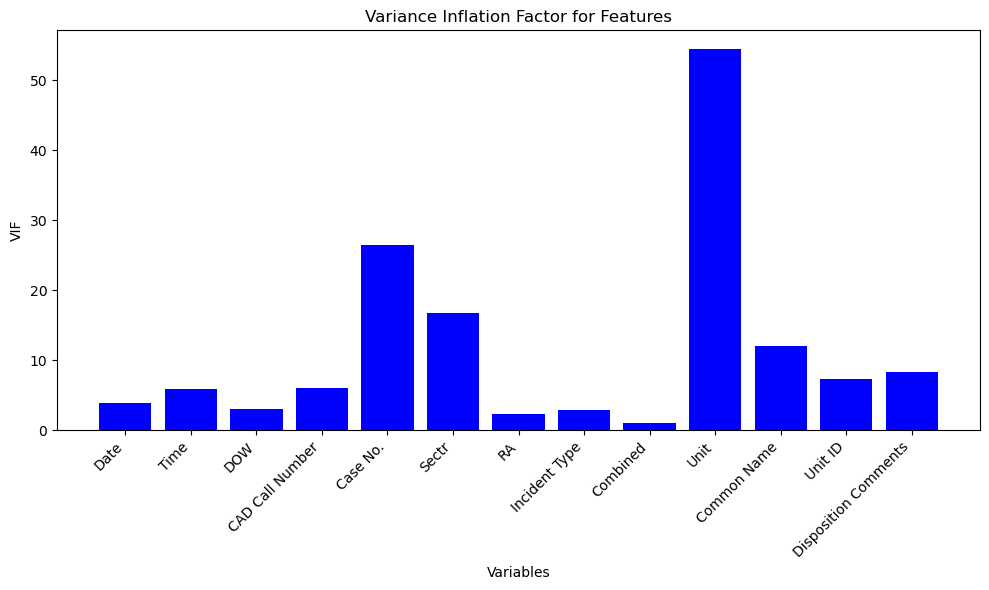

In [9]:
plt.figure(figsize=(10, 6))
plt.bar(vif_data['Variable'], vif_data['VIF'], color='blue')
plt.xlabel('Variables')
plt.ylabel('VIF')
plt.title('Variance Inflation Factor for Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()